# Simple Encoder CNN to get the $\phi_{CR}$ parameter of a CR image
---

---

In [2]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import h5py
from time import time
from datetime import datetime
from IPython import display as display_IPython

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the functions and routines for the DL
### Define the model and its constructor

In [3]:
class Simple_Encoder(nn.Module):
    def __init__(self, X=302, feats_1=15, feats_2=20, feats_3=20, feats_4=20,
                 prop1=3, prop2=2, prop3=1, av_pool1_div=4, conv4_feat_size=15, av_pool2_div=10, 
                 out_fc_1=10,
                 dropout_p1=0.2, dropout_p2=0.1
                ): 
        # propj is such that the_ image getting out from stage j is propj/prop_{j-1}-ths of the previous (with j=0 being 5)
        # clearly, prop_{j-1}>prop_{j}>...
        # 2X+1 will be assumed to be divisible by 5
        assert((2*X+1)%5==0)
        assert(prop1>prop2)
        assert(prop2>prop3)
        assert((int((prop3*(2*X+1)/5)/av_pool1_div)-conv4_feat_size)>0)
        
        
        super(Simple_Encoder, self).__init__()
        # in is [epoch_size, 1, 2X+1, 2X+1]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=feats_1, 
                               kernel_size = int((2*X+1)/5*(5-prop1)+1), bias=True) 
        # out conv1 [epoch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        self.conv2 = nn.Conv2d(in_channels=feats_1, out_channels=feats_2, 
                               kernel_size = int((2*X+1)/5*(prop1-prop2)+1), bias=True) 
        # out conv1 [epoch_size, feats_2, prop2*(prop1*(2X+1)/5)/prop1, prop2*(prop1*(2X+1)/5)/prop1]
        # that is [epoch_size, feats_2, prop2*(2X+1)/5), prop2*(2X+1)/5)]
        self.conv3 = nn.Conv2d(in_channels=feats_2, out_channels=feats_3, 
                               kernel_size = int((2*X+1)/5*(prop2-prop3)+1), bias=True)
        # out conv3 is [epoch_size, feats_3, prop3*(2X+1)/5), prop3*(2X+1)/5)]

        self.avPool1 = nn.AvgPool2d(kernel_size= int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        
        self.conv4 = nn.Conv2d(in_channels=feats_3, out_channels=feats_4, 
                              kernel_size= int((prop3*(2*X+1)/5)/av_pool1_div+1)-conv4_feat_size+1, bias=True)
        # [epoch_size, feats_4, conv4_feat_size, conv4_feat_size]
        
        self.avPool2 = nn.AvgPool2d(kernel_size= int(conv4_feat_size*(1-1/av_pool2_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_4, conv4_feat_size/av_pool2_div+1, conv4_feat_size/av_pool2_div+1]
        
        #self.in_fc = int(feats_4*(conv4_feat_size/av_pool2_div+1)**2)
        self.in_fc = feats_4*((((((2*X+1-int((2*X+1)/5*(5-prop1)+1)+1)
                                  -int((2*X+1)/5*(prop1-prop2)+1)+1)
                                 -int((2*X+1)/5*(prop2-prop3)+1)+1)
                                -int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) -1+1)
                               -int((prop3*(2*X+1)/5)/av_pool1_div+1)+conv4_feat_size-1+1)
                              -int(conv4_feat_size*(1-1/av_pool2_div)) -1+1)**2
        
        self.fc1 = nn.Linear(in_features=self.in_fc, out_features=out_fc_1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc_1, out_features=1, bias=True)
        
        self.dropout1 = nn.Dropout(p=dropout_p1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout_p2, inplace=False)
        self.relu = torch.nn.functional.relu

        self.batchNorm2 = nn.BatchNorm2d(num_features=feats_2)
        self.batchNorm4 = nn.BatchNorm2d(num_features=feats_4)

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]

        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]

        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]

        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]

        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]

        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]

        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, 1]
        
        return x
    
    def print_shapes(self, batch_size=10, X=302):
        x = torch.ones((batch_size, 1, 2*X+1, 2*X+1)).to(device)
        print(f"Initial shape {x.shape}")
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        print(f"Post Conv1+relu shape {x.shape}")
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]
        print(f"Post drop1+Conv2+relu+batchnorm shape {x.shape}")
        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]
        print(f"Post drop2+Conv3+relu shape {x.shape}")
        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        print(f"Post Av Pool1 shape {x.shape}")
        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]
        print(f"Post drop2+Conv4+batchnorm shape {x.shape}")
        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
        print(f"Post Av. Pool2 shape {x.shape}")
        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]
        print(f"Post Pre-fc shape {x.shape}")
        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, 1]
        print(f"Post fc1+relu+fc2 shape {x.shape}")

    

In [4]:
# subroutine to count number of parameters in the model
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

### The routines to validate and train

In [4]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate_epoch(criterion, model, dataloader, per_epoch_use_max_batches=None): #show_confusion_matrix = False):
    if per_epoch_use_max_batches is None:
        per_epoch_use_max_batches = len(dataloader)
    val_loss = 0
    max_abs_error = torch.Tensor([0]).to(device)
    mean_abs_error = 0
    preds = torch.Tensor().to(device)
    targets = torch.Tensor().to(device)

    model.eval() # disable the dropout, among others

    for batch_id, (data, target) in enumerate(dataloader):
        
        data, target = data.to(device), target.to(device)       
        prediction = model(data)
        target = target.view(prediction.shape)
        loss = criterion(prediction, target)
        val_loss += loss.item()                                                              
        max_abs_error = torch.maximum(torch.max(torch.abs(prediction-target), 0).values, max_abs_error)
        mean_abs_error += torch.sum(torch.abs(prediction-target), 0)
        if batch_id % per_epoch_use_max_batches == per_epoch_use_max_batches-1:
            break
    val_loss /= min(len(dataloader), per_epoch_use_max_batches)
    mean_abs_error /= min(len(dataloader), per_epoch_use_max_batches)
    #accuracy = 100. * correct / len(loader.dataset)
    print(f'\nValidation set: Average loss: {val_loss:.4f}, Average Abs Error: {np.array(mean_abs_error.cpu())}, Maximum Abs Error: {np.array(max_abs_error.cpu())} \n')

    #if show_confusion_matrix:
    #    visualize_confusion_matrix(preds.to(torch.device('cpu')), targets.to(torch.device('cpu')))

    return val_loss


def train_epoch(epoch, criterion, model, optimizer, dataloader, print_loss_every_batches=20,
                optimizer_step_every_batches=1, per_epoch_use_max_batches=None):
    if per_epoch_use_max_batches is None:
        per_epoch_use_max_batches = len(dataloader)
        
    total_loss = 0.0

    model.train()

    optimizer.zero_grad()
    #t = time()
    for batch_id, (data, target) in enumerate(dataloader):        

        data, target = data.to(device), target.to(device)
        prediction = model(data) # data is [batch_size, 1, 2X+1, 2X+1]
        loss = criterion(prediction, target)
        loss.backward()
        
        if batch_id % optimizer_step_every_batches==optimizer_step_every_batches-1:
            optimizer.step()
            optimizer.zero_grad()
        # print loss every N batches
        if batch_id % print_loss_every_batches == print_loss_every_batches-1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_id+1) * len(data), len(dataloader)*batch_size,
                100*(batch_id+1)*len(data) / (len(dataloader)*batch_size), loss.item()))

        if batch_id % per_epoch_use_max_batches == per_epoch_use_max_batches-1:
            break
        #t9=time()
        #print(f"it time {t9-t}")

        total_loss += loss.item()  #.item() is very important here
        # In order to avoid having total_loss as a tensor in the gpu
        #t = time()

    return total_loss / min(len(dataloader), per_epoch_use_max_batches)

### The full training loop

In [5]:
def full_training_loop(model, criterion, optimizer, train_loader, test_loader, epochs=10,
                       print_loss_every_batches=20, validate_every_epochs=2, optimizer_step_every_batches=1,
                      per_epoch_use_max_train_batches=None, per_epoch_use_max_test_batches=None,
                      image_path=None, save_model_every_epochs=1, model_path=None):
    losses = {"train": [], "val": []}
    %matplotlib inline
    for epoch in range(epochs):

        train_loss = train_epoch(epoch, criterion, model, optimizer, train_loader,
                                 print_loss_every_batches=print_loss_every_batches,
                                optimizer_step_every_batches=optimizer_step_every_batches,
                                per_epoch_use_max_batches=per_epoch_use_max_train_batches)
        if epoch%validate_every_epochs==0 and epoch!=0:
            val_loss = validate_epoch(criterion, model, test_loader, per_epoch_use_max_test_batches)
        else:
            val_loss = train_loss
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)        
        plt.plot(losses["train"], label="log training loss")
        plt.plot(losses["val"], label="log validation loss")
        plt.yscale('log')
        plt.legend()
        if image_path is not None:
            plt.savefig(image_path)
            plt.clf()
        else:
            display_IPython.clear_output(wait=True)
            plt.pause(0.001)
            plt.show()
        if epoch % save_model_every_epochs==save_model_every_epochs-1 and model_path:
            torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, model_path)

    return losses

### The Dataset class and Data Sampler

In [5]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, GT_file_path, images_dir_path):
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(GT_file_path)))
        self.images_dir_path = images_dir_path
        self.len_data = len(self.df_GTs)

    def __len__(self):
        return self.len_data

    def __getitem__(self, idx):
        img_path = f"{self.images_dir_path}/IM_{self.df_GTs.iloc[idx,0]}_phiCR_{self.df_GTs.iloc[idx,1]}.png"
        image = read_image(img_path) #[1, 2X+1, 2X+1] torch tensor
        label = torch.Tensor([float(self.df_GTs.iloc[idx, 1])]).type(torch.float32) #[1] torch tensor of float32
        return image, label

---
# Initialize the dataset and sampler (choose the number of batches per epoch, and their length) and fix the artificial noise hyperparameters

Note that since in each epoch the dataset shown to the model will be random, we can use the same dataset as a validation set.

In [6]:
#GT_file_path_train = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TRAIN/GROUND_TRUTHS.json"
#images_dir_path_train =f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TRAIN/" 
#GT_file_path_test = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TEST/GROUND_TRUTHS.json"
#images_dir_path_test = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TEST/"

GT_file_path_train = f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TRAIN/GROUND_TRUTHS.json"
images_dir_path_train =f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TRAIN/" 
GT_file_path_test = f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TEST/GROUND_TRUTHS.json"
images_dir_path_test =f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TEST/" 

total_epochs = 10000
batch_size = 10
validate_every_epochs = 1100
optimizer_step_every_batches = 10
per_epoch_use_max_train_batches= 300
per_epoch_use_max_test_batches=20
save_model_every_epochs = 1

worker_num=5

# 6 segundos por batch de 10 unidades, hacemos que pasen 40.000 batches (400.000 imagenes)
# lo haremos de forma que se de una optimizer step cada 4 batches, en 10 epochs de 
# cada una 4000 batches (para plotear la curva) 
# y tras cada epoch haremos un save del modelo
# deberian ser 2.8 dias de training

# todo esto dividido por dos de forma que podemos entrenar simulatnaeamente ambos modelos? (con noisy y non-noisy data)

In [8]:
training_data = ImageDataset(GT_file_path_train, images_dir_path_train)
test_data = ImageDataset(GT_file_path_test, images_dir_path_test)

In [9]:
torch.manual_seed(678)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=worker_num,
                              pin_memory=True, drop_last=False, persistent_workers=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=worker_num, 
                             pin_memory=True, drop_last=False, persistent_workers=False)


assert(len(train_dataloader)%batch_size==0) # make batch_size an integer proportion of data files
batch_number_per_epoch = len(train_dataloader)/batch_size
assert(batch_number_per_epoch%optimizer_step_every_batches==0) # make optimizer steps every divisble number of its

# Fix the Hyperparameters and Initialize the Model and the Optimizer

In [7]:
X=302
feats_1=20
feats_2=20
feats_3=20
feats_4=5
prop1=2.5
prop2=1.5
prop3=0.6
av_pool1_div=2
conv4_feat_size=8
av_pool2_div=10
out_fc_1=5
dropout_p1=0.2
dropout_p2=0.1

In [11]:
model = Simple_Encoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                 prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, 
                av_pool2_div=av_pool2_div, 
                 out_fc_1=out_fc_1,
                 dropout_p1=dropout_p1, dropout_p2=dropout_p2 ) 

print(f"Number of parameters {get_n_params(model)}")

# In case we wish to transfer the learned parameters of another run
check_file="Noisy_Model_and_Optimizer_2022-01-18 11:37:26.485463.pt"
checkpoint = torch.load(f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/{check_file}")

# move model to gpu if available
model.to(device)
model.print_shapes()

model.load_state_dict(checkpoint['model'])


# Initialize the weights of the model! Default initialization might already be fine!

# we can use a MSE loss for the regression task we have in hands
criterion = nn.MSELoss()

# we will choose as optimizer the 
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.01, weight_decay=0.3,
#                                initial_accumulator_value=0, eps=1e-10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.99, 0.9999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer.load_state_dict(checkpoint['optimizer'])

Number of parameters 12632406
Initial shape torch.Size([10, 1, 605, 605])
Post Conv1+relu shape torch.Size([10, 20, 303, 303])
Post drop1+Conv2+relu+batchnorm shape torch.Size([10, 20, 182, 182])
Post drop2+Conv3+relu shape torch.Size([10, 20, 74, 74])
Post Av Pool1 shape torch.Size([10, 20, 38, 38])
Post drop2+Conv4+batchnorm shape torch.Size([10, 5, 9, 9])
Post Av. Pool2 shape torch.Size([10, 5, 2, 2])
Post Pre-fc shape torch.Size([10, 20])
Post fc1+relu+fc2 shape torch.Size([10, 1])


# Run the Training

In [12]:
%%time
losses = full_training_loop(model, criterion, optimizer, train_dataloader, test_dataloader, 
                    epochs=total_epochs, print_loss_every_batches=100,
                            validate_every_epochs=validate_every_epochs,
                           optimizer_step_every_batches=optimizer_step_every_batches,
                           per_epoch_use_max_train_batches=per_epoch_use_max_train_batches, 
                            per_epoch_use_max_test_batches=per_epoch_use_max_test_batches,
                           image_path=f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/Noisy_Training_{datetime.now()}.png",
                           save_model_every_epochs=save_model_every_epochs, 
                            model_path=f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/Noisy_Model_and_Optimizer_{datetime.now()}.pt"
                           )
# Execute the training and validation

Train Epoch: 0 [1000/500000 (0%)]	Loss: 0.013808
Train Epoch: 0 [2000/500000 (0%)]	Loss: 0.396808
Train Epoch: 0 [3000/500000 (1%)]	Loss: 0.021259
Train Epoch: 1 [1000/500000 (0%)]	Loss: 3.339910
Train Epoch: 1 [2000/500000 (0%)]	Loss: 0.041985
Train Epoch: 1 [3000/500000 (1%)]	Loss: 0.035930
Train Epoch: 2 [1000/500000 (0%)]	Loss: 0.044560
Train Epoch: 2 [2000/500000 (0%)]	Loss: 0.061151
Train Epoch: 2 [3000/500000 (1%)]	Loss: 0.261909
Train Epoch: 3 [1000/500000 (0%)]	Loss: 0.012431
Train Epoch: 3 [2000/500000 (0%)]	Loss: 0.207728
Train Epoch: 3 [3000/500000 (1%)]	Loss: 0.024111
Train Epoch: 4 [1000/500000 (0%)]	Loss: 0.026593
Train Epoch: 4 [2000/500000 (0%)]	Loss: 0.049630
Train Epoch: 4 [3000/500000 (1%)]	Loss: 0.035724
Train Epoch: 5 [1000/500000 (0%)]	Loss: 3.186608
Train Epoch: 5 [2000/500000 (0%)]	Loss: 0.012644
Train Epoch: 5 [3000/500000 (1%)]	Loss: 1.197880
Train Epoch: 6 [1000/500000 (0%)]	Loss: 0.163347
Train Epoch: 6 [2000/500000 (0%)]	Loss: 0.008245
Train Epoch: 6 [3000

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

Vale, el pb es exclusivamente el Backjprop, ni es el data transfer (ya ke el crazy no improvea el tiempo practicamente), ni es nigun print. Tb un poco es el model inference, ke es la mitad del tiempo de cada batch! 


Turns out ke unos 7 segdos y medio son inferencia y 25 en total si haces backward -backpropagate-.
Asike todo el tiempo gordo, no es ni el retrieval (image library o in situ generation), ni el sending al device (ya ke sendeas o no en cada batch no cambia tpco casi), ni los prints:
Son 1/3 del tiempo el inference, y 2/3 del tiempo el backpropagate!

LA cosa es en si ppodrias hacer backward solo cuando hagas el step del optimizer y no en cada batch. Lo ke pasa es ke tienes el trade off de ke iras acumulando cada vez un computational graph mas grande! Asike kizas no cunda, porke la memoria se ira llenando mas, y en realidad kizas sea secuencial el backprop ke ejekutes?

Pues lo he probado y efectivamente, las batches sin backprop son de 7 y pico secs, pero luego la cuarta (cadda 4 se hace backw pa hacer step), es de 80 secs, en total, 100 secs, como si cada uno hubiese tardado 25 secs. En fin, no hay solucion magica: Solo una-> hacer el modelo mas pequeño...

# Save the resulting model weights

In [15]:
torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/Noisy_Model_opt_Adam_it_1_8sperbatchx10batchperepx20epochs_samples_feats_1={feats_1}_feats_2={feats_2}_feats_3={feats_3}_feats_4={feats_4}_prop1={prop1}_prop2={prop2}_prop3={prop3}_av_pool1_div={av_pool1_div}_conv4_feat_size={conv4_feat_size}_av_pool2_div={av_pool2_div}_out_fc_1={out_fc_1}_dropout_p1={dropout_p1}_dropout_p2={dropout_p2}.pt")

# Final Validation

In [14]:
print("\n\n\nFINAL VALIDATION! ####################################################\n\n")
print("Train Set")
#validate_epoch(nn.MSELoss(), model, sampler, dataset, per_epoch_use_max_train_batches)
print("Test Set")
validate_epoch(nn.MSELoss(), model, test_dataloader, per_epoch_use_max_test_batches)




FINAL VALIDATION! ####################################################


Train Set
Test Set


Traceback (most recent call last):
  File "/home/oiangu/anaconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/oiangu/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/oiangu/anaconda3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/oiangu/anaconda3/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/oiangu/anaconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/oiangu/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/oiangu/anaconda3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/oiangu/anaconda3/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/oiangu/anaconda3/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/oiangu/anaconda3/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/oiangu/anaconda3/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [ ]:
raise ValueError

# Charge models and do inference

In [8]:
checkpoint = torch.load(f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/Noisy_Model_and_Optimizer_2022-01-24 19:57:31.886991.pt")

model = Simple_Encoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                 prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, av_pool2_div=av_pool2_div, 
                 out_fc_1=out_fc_1,
                 dropout_p1=dropout_p1, dropout_p2=dropout_p2 ) 

model.to(device)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [9]:
def compute_intensity_gravity_centers(images):
    """
        Expects input image to be an array of dimensions [N_imgs, h, w].
        It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to array indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
    intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
    total_intensity = intensity_in_h.sum(dim=1) # [N_images]

    # Compute mass center for intensity
    # [N_images, 2] (h_center,w_center)
    return torch.nan_to_num( torch.stack(
        (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                    dtype=torch.float32, device=device))/total_intensity,
         torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                    dtype=torch.float32, device=device))/total_intensity),
        dim=1
        ), nan=0.0, posinf=None, neginf=None)

def compute_raw_to_centered_iX(images, X=302):

        g_raw = compute_intensity_gravity_centers(images) # [ N_images, 2]

        # crop the iamges with size (X+1+X)^2 leaving the gravity center in
        # the central pixel of the image. In case the image is not big enough for the cropping,
        # a 0 padding will be made.
        centered_images = torch.zeros( ( images.shape[0], 2*X+1, 2*X+1),  dtype = images.dtype, 
                                      device=device)

        # we round the gravity centers to the nearest pixel indices
        g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

        # obtain the slicing indices around the center of gravity
        # TODO -> make all this with a single array operation by stacking the lower and upper in
        # a new axis!!
        # [ N_images, 2 (h,w)]
        unclipped_lower = g_index_raw-X
        unclipped_upper = g_index_raw+X+1

        # unclipped could get out of bounds for the indices, so we clip them
        lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
        upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
        # we use the difference between the clipped and unclipped to get the necessary padding
        # such that the center of gravity is left still in the center of the image
        padding_lower = lower_bound-unclipped_lower
        padding_upper = upper_bound-unclipped_upper

        # crop the image
        for im in range(g_raw.shape[0]):
            centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                        padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                      images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                          lower_bound[ im, 1]:upper_bound[ im, 1]]

        return centered_images

In [20]:
# Create and display a FileChooser widget
from ipyfilechooser import FileChooser
path="/home/oiangu/Desktop/Conical_Refraction_Polarimeter"
fc = FileChooser(path+'/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/')
display(fc)

FileChooser(path='/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser…

### Choose a single experimental image to predict

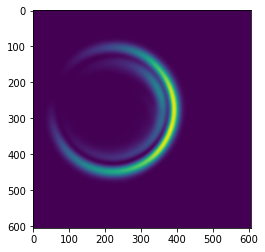

In [21]:
import cv2
image_full_path=fc.selected
#image_full_path="/home/oiangu/Desktop/Conical_Refraction_Polarimeter/Experimental_Stuff/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/sin_el_positivo.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)
if im is None:
    print(f" Unable to import image {image_full_path}")
    raise ValueError
# Center in gravicenter, generating iX
im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

### Plot its Profiles

<IPython.core.display.Javascript object>


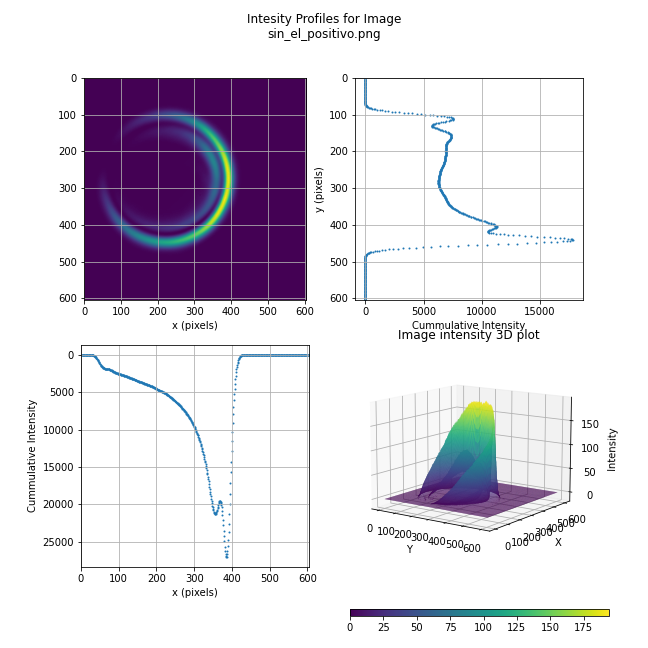

In [22]:
plot3d_resolution=0.7

%matplotlib notebook

prof_x=np.sum(im, axis=0)
prof_y=np.sum(im, axis=1)
fig = plt.figure(figsize=(2*4.5, 2*4.5))
axes=fig.subplots(2,2)

cm=axes[0, 0].imshow(im, cmap='viridis')
axes[0,0].grid(True)
axes[0,1].scatter(prof_y, np.arange(len(prof_y)), s=1, label=f'Intensity profile in y')
axes[0,1].set_ylim((0,len(prof_y)))
axes[0,1].invert_yaxis()
axes[1,0].scatter(np.arange(len(prof_x)), prof_x, s=1, label=f'Intensity profile in y')
axes[1,0].set_xlim((0,len(prof_x)))
axes[1,0].invert_yaxis()
axes[0,0].set_xlabel("x (pixels)")
#axes[0,0].set_ylabel("y (pixels)")
axes[0,1].set_xlabel("Cummulative Intensity")
axes[0,1].set_ylabel("y (pixels)")
axes[1,0].set_ylabel("Cummulative Intensity")
axes[1,0].set_xlabel("x (pixels)")
axes[1,0].grid(True)
axes[0,1].grid(True)
axes[1,1].set_visible(False)
ax = fig.add_subplot(224, projection='3d')
Xs,Ys = np.meshgrid(np.arange(len(prof_y)),np.arange(len(prof_x)))
fig.suptitle(f"Intesity Profiles for Image\n{image_full_path.split('/')[-1]}")
files_for_gif=[]
cbax=fig.add_axes([0.54,0.05,0.4,0.01])
fig.colorbar(cm, ax=axes[0,0], cax=cbax, orientation='horizontal')
theta=25
phi=30
ax.plot_surface(Xs, Ys, im.T, rcount=int(len(prof_y)*plot3d_resolution), ccount=int(len(prof_x)*plot3d_resolution), cmap='viridis') # rstride=1, cstride=1, linewidth=0
#cset = ax.contourf(X, Y, im, 2, zdir='z', offset=-20, cmap='viridis', alpha=0.5)
#cset = ax.contourf(X, Y, im, 1, zdir='x', offset=-8, cmap='viridis')
#cset = ax.contourf(X, Y, im, 1, zdir='y', offset=0, cmap='viridis')
ax.set_xlabel('Y')
#ax.set_xlim(-8, 8)
ax.set_ylabel('X')
#ax.set_ylim(-10, 8)
ax.set_zlabel('Intensity')
ax.set_zlim(-0.078*np.max(im), np.max(im))
ax.set_title("Image intensity 3D plot")
ax.view_init(10, theta)
#ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1.3, 1.3, 1.3, 1]))
plt.show()

### Get NN predictions for $R_0, w_0, \phi_{CR}, Z$

In [23]:
print("Custom")
model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
print(f"Predicted phi_CR {predictions[0]} rad {predictions[0]*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {predictions[0]/2} rad {predictions[0]*180/np.pi/2} deg")

Custom
Predicted phi_CR -0.24560868740081787 rad -14.072340965270996 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.12280434370040894 rad -7.036170482635498 deg


Referencia sin nada



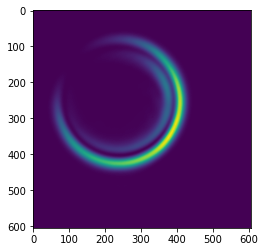

Predicted phi_CR -0.42899301648139954 rad -24.579489284970357 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.21449650824069977 rad -12.289744642485179 deg


In [11]:
import cv2
print("Referencia sin nada\n")
%matplotlib inline
image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/sin_los_dos_solo_tubo.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
ref=predictions[0].item()
print(f"Predicted phi_CR {ref} rad {ref*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {ref/2} rad {ref*180/np.pi/2} deg")

Referencia sin nada



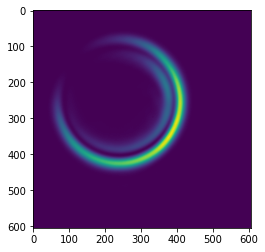

Predicted phi_CR -0.4323200583457947 rad -24.770114742063537 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.21616002917289734 rad -12.385057371031769 deg


In [12]:
print("Referencia sin nada\n")
%matplotlib inline
image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/antes_de_la_estandar.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
ref2=predictions[0].item()
print(f"Predicted phi_CR {ref2} rad {ref2*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {ref2/2} rad {ref2*180/np.pi/2} deg")

Sin el negativo



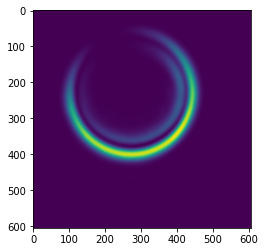

Predicted phi_CR -1.1212823390960693 rad -64.2447456727616 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.5606411695480347 rad -32.1223728363808 deg


In [13]:
print("Sin el negativo\n")
%matplotlib inline

image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/sin_el_negativo.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
pos=predictions[0].item()
print(f"Predicted phi_CR {pos} rad {pos*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {pos/2} rad {pos*180/np.pi/2} deg")

Sin el positivo



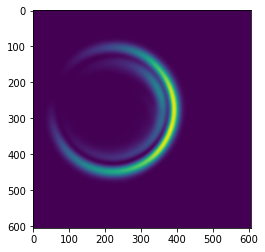

Predicted phi_CR -0.24560868740081787 rad -14.07234119981482 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.12280434370040894 rad -7.03617059990741 deg


In [14]:
print("Sin el positivo\n")
%matplotlib inline

image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/sin_el_positivo.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
neg = predictions[0].item()
print(f"Predicted phi_CR {neg} rad {neg*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {neg/2} rad {neg*180/np.pi/2} deg")

Con ambos



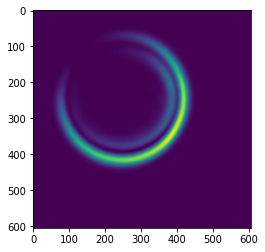

Predicted phi_CR -0.5177052021026611 rad -29.662323112449794 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.25885260105133057 rad -14.831161556224897 deg


In [15]:
print("Con ambos\n")
%matplotlib inline

image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/con_los_dos.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
both=predictions[0].item()
print(f"Predicted phi_CR {both} rad {both*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {both/2} rad {both*180/np.pi/2} deg")


Ref Ort



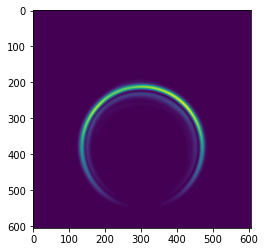

Predicted phi_CR 1.7065927982330322 rad 97.780564686174 deg


Predicted Polarization plane -relative to the image plane w axis- is 0.8532963991165161 rad 48.890282343087 deg


In [16]:
print("Ref Ort\n")
%matplotlib inline

image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day3/Reference/Reference__100.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
ref_ort=predictions[0].item()
print(f"Predicted phi_CR {ref_ort} rad {ref_ort*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {ref_ort/2} rad {ref_ort*180/np.pi/2} deg")


Ref Ort



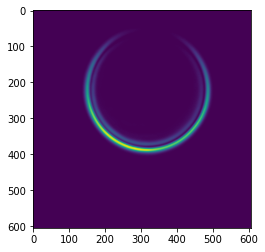

Predicted phi_CR 1.7065927982330322 rad -83.66577386066756 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.7301216125488281 rad -41.83288693033378 deg


In [17]:
print("Ref Ort\n")
%matplotlib inline

image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day3/Problem/90__100.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
predictions = model(torch.from_numpy(im).to(device).unsqueeze(0))[0]
ort=predictions[0].item()
print(f"Predicted phi_CR {ref_ort} rad {ort*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {ort/2} rad {ort*180/np.pi/2} deg")


In [19]:
print(f"Positivo-Ref deberian ser {13.85} deg son {(pos-ref)*180/np.pi/2} deg")
print(f"Negativo-Ref deberian ser {9.45} deg son {(neg-ref)*180/np.pi/2} deg")
print(f"Ambos-Ref deberian ser {4.4} deg son {(both-ref)*180/np.pi/2} deg\n")

print(f"Positivo-Ref2 deberian ser {13.85} deg son {(pos-ref2)*180/np.pi/2} deg")
print(f"Negativo-Ref2 deberian ser {9.45} deg son {(neg-ref2)*180/np.pi/2} deg")
print(f"Ambos-Ref2 deberian ser {4.4} deg son {(both-ref2)*180/np.pi/2} deg\n")

print(f"Ref2-Ref deberian ser {0} deg son {(ref2-ref)*180/np.pi/2} deg\n")

print(f"El de noventa deberian ser {90} deg son {(ref_ort-ort)*180/np.pi/2} deg")

Positivo-Ref deberian ser 13.85 deg son -19.83262819389562 deg
Negativo-Ref deberian ser 9.45 deg son 5.253574042577769 deg
Ambos-Ref deberian ser 4.4 deg son -2.541416913739718 deg

Positivo-Ref2 deberian ser 13.85 deg son -19.73731546534903 deg
Negativo-Ref2 deberian ser 9.45 deg son 5.348886771124358 deg
Ambos-Ref2 deberian ser 4.4 deg son -2.446104185193129 deg

Ref2-Ref deberian ser 0 deg son -0.09531272854658919 deg

El de noventa deberian ser 90 deg son 90.72316927342078 deg


### Get the non-black-box algorithm estimate for $\phi_{CR}$

In [ ]:
import os
os.chdir(f"../../..")
import sys
from SOURCE.CLASS_CODE_GPU_Classes import *
from SOURCE.CLASS_CODE_Image_Manager import *
from SOURCE.CLASS_CODE_Polarization_Obtention_Algorithms import Rotation_Algorithm, Mirror_Flip_Algorithm, Gradient_Algorithm
import numpy as np
import json
import cv2
import pandas as pd
import matplotlib.pyplot as plt

image=im.copy()
saturation=0.9
pol_or_CR="pol" 
deg_or_rad="deg" # for the final output
image_depth=8 # or 16 bit per pixel
image_shortest_side=540
randomization_seed=666
recenter_average_image=False


# 5. POLARIZATION RELATIVE ANGLES ###################################
# Mirror with affine interpolation & Rotation Algorithms will be employed
# Each using both Fibonacci and Quadratic Fit Search
# Also a gradient algorithm
theta_min_Rot=-np.pi
theta_max_Rot=np.pi
rad_min_Grav=3
rad_max_Grav=image_shortest_side
theta_min_Mir=0
theta_max_Mir=np.pi
initial_guess_delta_rad=0.1
initial_guess_delta_pix=10
use_exact_gravicenter=True
precision_quadratic=1e-10
max_it_quadratic=100
cost_tolerance_quadratic=1e-14
precision_fibonacci=1e-10
max_points_fibonacci=100
cost_tolerance_fibonacci=1e-14


##################################################################
##################################################################
im_type=np.uint16 if image_depth==16 else np.uint8
max_intensity=65535 if image_depth==16 else 255
np.random.seed(randomization_seed)
polCR=1 if pol_or_CR=='CR' else 0.5

# 6. POLARIZATION RELATIVE ANGLES ###################################
# Mirror with affine interpolation & Rotation Algorithms will be employed
# Each using both Fibonacci and Quadratic Fit Search
# Results will be gathered in a table and outputed as an excel csv
# Mock Image Loader
# Computar el angulo de cada uno en un dataframe donde una de las entradas sea results y haya un result per fibo qfs y per rotation y mirror affine. Y luego procesar en un 7º paso estos angulos para obtener los angulos relativos etc y perhaps hacer tablucha con ground truth menos el resulting delta angle medido por el algoritmo
image_loader = Image_Manager(mode=X, interpolation_flag=None)
# Define the ROTATION ALGORITHM
rotation_algorithm = Rotation_Algorithm(image_loader,
    theta_min_Rot, theta_max_Rot, None,
    initial_guess_delta_rad, use_exact_gravicenter, initialize_it=False)

# Define the Affine Mirror algorithm
mirror_algorithm = Mirror_Flip_Algorithm(image_loader,
    theta_min_Mir, theta_max_Mir, None,
    initial_guess_delta_rad, method="aff", left_vs_right=True, use_exact_gravicenter=use_exact_gravicenter, initialize_it=False)

# Define the Gradient algorithm
gradient_algorithm = Gradient_Algorithm(image_loader,
        rad_min_Grav, rad_max_Grav,
        initial_guess_delta_pix,
        use_exact_gravicenter)

# A dictionary to gather all the resulting angles for each image

individual_image_results = { 'polarization_method':[], 'optimization_1d':[], 'found_phiCR':[], 'predicted_opt_precision':[] }

def to_result_dict(result_dict, alg, alg_name, opt_name, im_names):
    for key, name in zip(alg.times.keys(), im_names):
        result_dict['polarization_method'].append(alg_name)
        result_dict['optimization_1d'].append(opt_name)
        result_dict['found_phiCR'].append(alg.angles[key])
        result_dict['predicted_opt_precision'].append(alg.precisions[key])
image_container=np.zeros( (1, 2*X+1, 2*X+1), dtype=np.float64)
image_names=[]
# charge the image
image_container[0]=image.astype(np.float64)
image_names.append(f"{fc.selected_filename}")

# charge the image loader:
image_loader.import_converted_images_as_array(image_container, image_names)
# Execute the Rotation and Mirror Algorithms:
# ROTATION ######
interpolation_flag=None
# the interpolation algorithm used in case we disbale its usage for the iX image obtention will be the Lanczos one
rotation_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
rotation_algorithm.reInitialize(image_loader)
rotation_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, rotation_algorithm, "Rotation", "Quadratic", image_names)
rotation_algorithm.reInitialize(image_loader)
rotation_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, rotation_algorithm, "Rotation", "Fibonacci", image_names)

# MIRROR #######
mirror_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
mirror_algorithm.reInitialize(image_loader)
mirror_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, rotation_algorithm, "Mirror", "Quadratic", image_names)
mirror_algorithm.reInitialize(image_loader)
mirror_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, rotation_algorithm, "Mirror", "Fibonacci", image_names)

# GRADIENT #######
def compute_intensity_gravity_center(image):
    """
        Expects input image to be an array of dimensions [h, w].
        It will return an array of gravity centers [2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to numpy indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

optimal_masked_gravs={}
optimal_radii={}
grav=compute_intensity_gravity_center(image)

gradient_algorithm.interpolation_flag=interpolation_flag if interpolation_flag is not None else cv2.INTER_CUBIC
gradient_algorithm.reInitialize(image_loader)
gradient_algorithm.quadratic_fit_search(precision_quadratic, max_it_quadratic, cost_tolerance_quadratic)
to_result_dict( individual_image_results, gradient_algorithm, "Gradient", "Quadratic", image_names)
#optimal_masked_gravs['quad'] = gradient_algorithm.masked_gravs[f"Quadratic_Search_{fc.selected_filename}"]
#optimal_radii['quad'] = gradient_algorithm.optimals[f"Quadratic_Search_{fc.selected_filename}"]

gradient_algorithm.reInitialize(image_loader)
gradient_algorithm.fibonacci_ratio_search(precision_fibonacci, max_points_fibonacci, cost_tolerance_fibonacci)
to_result_dict( individual_image_results, gradient_algorithm, "Gradient", "Fibonacci", image_names)

#optimal_masked_gravs['fibo'] = gradient_algorithm.masked_gravs[f"Fibonacci_Search_{fc.selected_filename}"]
#optimal_radii['fibo'] = gradient_algorithm.optimals[f"Fibonacci_Search_{fc.selected_filename}"]

#masked_grav=(optimal_masked_gravs['quad']+optimal_masked_gravs['fibo'])/2.0
#optimal_radi = (optimal_radii['quad']+optimal_radii['fibo'])/2
#print(f"\n\nOptimal masked gravs: {optimal_masked_gravs}\nOptimal radii: {optimal_radii}\n\n\n")
print(pd.DataFrame.from_dict(individual_image_results))

# 7. PROCESS FINAL RESULTS ##########################################
def angle_to_pi_pi( angle): # convert any angle to range ()-pi,pi]
    angle= angle%(2*np.pi) # take it to [-2pi, 2pi]
    return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle    

average_found_phiCR=np.mean([angle_to_pi_pi(phi) for i,phi in enumerate(individual_image_results['found_phiCR']) if individual_image_results['polarization_method'][i]!='Gradient'])
print("Average found phiCR:", average_found_phiCR)
#print(f"\n\nPredicted slope for main axis: by Gradient {(masked_grav[0]-grav[0])/(masked_grav[1]-grav[1])} and by the others averaged {np.tan(-average_found_phiCR)}")

In [ ]:
'''
def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
    x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]) # [batch_size, 1, 2X+1, 2X+1]
    X=302
    feats_1=15
    feats_2=20
    feats_3=20
    feats_4=20
    prop1=3
    prop2=2
    prop3=1
    av_pool1_div=4
    conv4_feat_size=15
    av_pool2_div=10
    out_fc_1=10 
    print(x.shape, 2*X+1)

    x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
    print("conv1",x.shape, prop1*(2*X+1)/5)


    x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]
    print("conv2",x.shape,  prop2*(2*X+1)/5)


    x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]
    print("conv3",x.shape,  prop3*(2*X+1)/5)


    x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
    print("av_pool1",x.shape, int((prop3*(2*X+1)/5)/av_pool1_div))


    x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]
    print("conv4+batchn",x.shape, conv4_feat_size)


    x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]
    print("av_pool2",x.shape, int(conv4_feat_size/av_pool2_div)+1)


    x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]
    print("view_change",x.shape, feats_4*int(conv4_feat_size/av_pool2_div+1)**2)


    x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, 4]
    print(x.shape, 4)

        return x
a = Simple_Encoder().to(device)
a(torch.ones(2,1, 605,605).to(device))
del a
torch.cuda.empty_cache()
'''

In [ ]:
def train_crazy_epoch(epoch, criterion, model, optimizer, datas, targets, batch_number, batch_size,
                      print_loss_every_batches=20,
                    optimizer_step_every_batches=1):
    
    total_loss = 0.0

    model.train()

    optimizer.zero_grad()
    t2 = time()
    for k in range(batch_number):        
        
        prediction = model(datas[k*batch_size:(k+1)*batch_size]) # data is [batch_size, 1, 2X+1, 2X+1]
        loss = criterion(prediction, targets[k*batch_size:(k+1)*batch_size])
        loss.backward()
        
        if k % optimizer_step_every_batches==optimizer_step_every_batches-1:
            optimizer.step()
            optimizer.zero_grad()
        # print loss every N batches
        if k % print_loss_every_batches == print_loss_every_batches-1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (k+1) * batch_size, len(datas),
                100*(k+1)*batch_size / len(datas), loss.item()))

        #total_loss += loss.item()  #.item() is very important here
        # Why?-> In order to avoid having total_loss as a tensor in the gpu
        t1= time()
        print(f"Iteration time{t1-t2}")
        t2 = time()

    return total_loss / len(datas)

In [ ]:
def full_crazy_training_loop(model, criterion, optimizer_generator, train_loader,
                             batch_number, batch_size, epochs=10,
                       print_loss_every_batches=20, optimizer_step_every_batches=1,
                            meta_epoch_number=1):
    %matplotlib inline
    for meta_epoch in range(meta_epoch_number):
        for meta_batch_id, (datas, targets) in enumerate(train_loader):        
            datas, targets = datas.to(device), targets.to(device) # pero muuh gordos
            losses = {"train": []}
            optimizer = optimizer_generator(model)
            for epoch in range(epochs): # que overfitee el muuh gordo este
                train_loss = train_crazy_epoch(epoch, criterion, model, optimizer, datas,
                                         targets, batch_number, batch_size,
                                          print_loss_every_batches=20,
                                            optimizer_step_every_batches=1)

                display_IPython.clear_output(wait=True)
                losses["train"].append(train_loss)
                plt.plot(losses["train"], label=f"log training loss- MetaBatch {meta_batch_id/len(train_loader)*100}%")
                plt.yscale('log')
                plt.legend()
                plt.pause(0.001)
                plt.show()   
    return losses

In [ ]:
meta_epoch_number = 1
meta_batch_size = 100
batch_size = 10
batch_number = int(meta_batch_size/batch_size)
assert(meta_batch_size%batch_size==0)

crazy_loader = DataLoader(training_data, batch_size=meta_batch_size, shuffle=True, num_workers=worker_num,
                              pin_memory=True, drop_last=False, persistent_workers=False)

def adam_generator(model):
    return torch.optim.Adam(model.parameters(), lr=0.05, betas=(0.99, 0.9999), eps=1e-08, weight_decay=0, amsgrad=False)

full_crazy_training_loop(model, criterion, 
                         adam_generator, 
                         crazy_loader,
                             batch_number, batch_size, epochs=10,
                       print_loss_every_batches=10, optimizer_step_every_batches=2, 
                         meta_epoch_number=meta_epoch_number)

In [ ]:
t1=time()
for datas, targets in train_dataloader:
    datas, targets = datas.to(device), targets.to(device)
    pred = model(datas)
    t2=time()
    print(f"inf time {t2-t1}")
    loss = criterion(pred, targets)
    loss.backward()
    t3=time()
    print(f"with backward {t3-t1}")
    t1=time()